In [1]:
import os
os.chdir('./drive/My Drive/Colab Notebooks/book_code/object_detection')

In [2]:
import tensorflow as tf
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization, Flatten, add, Activation, Concatenate
from tensorflow.keras.layers import Input, Reshape, Layer
from tensorflow.keras.models import Model

print(tf.__version__)

2.3.0


## Computation

In [237]:
def center_to_corner(boxes):
  corner_left_top = boxes[:, :2] - boxes[:, 2:] / 2.0
  corner_right_bottom = boxes[:, :2] + boxes[:, 2:] / 2.0

  return tf.concat([corner_left_top, corner_right_bottom], axis = -1)

def corner_to_center(box):
  center_x = box[:, 0] + box[:, 2] / 2.0
  center_y = box[:, 1] + box[:, 3] / 2.0

  return tf.stack([center_x, center_y, box[:, 2], box[:, 3]], axis = 1)

def convert_to_wh(box):
  return tf.stack([box[:, 0], box[:, 1], 
                      box[:, 2] - box[:, 0], 
                      box[:, 3] - box[:, 1]], axis = 1)

def compute_jaccard(boxes1, boxes2):
  '''
    boxes1: (gt_boxes, 4)
    boxes2: (default_boxes, 4)

    Returns:
      (gt_boxes, default_boxes): jaccard value
  '''

  # (cx, cy, width, height)를 왼쪽위 꼭짓점과 오른쪽 아래 꼭짓점으로 변환합니다.
  boxes1_corner = center_to_corner(boxes1)
  boxes2_corner = center_to_corner(boxes2)

  # intersection box의 왼쪽위 꼭짓점과 오른쪽아래 꼭짓점을 구합니다.
  left_top = tf.maximum(boxes1_corner[:, None, :2], boxes2_corner[:, :2])
  right_bottom = tf.minimum(boxes1_corner[:, None, 2:], boxes2_corner[:, 2:])

  intersection = tf.maximum(0.0, right_bottom - left_top)
  intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
  boxes1_area = boxes1[:, 2] * boxes1[:, 3]
  boxes2_area = boxes2[:, 2] * boxes2[:, 3]

  union_area = tf.maximum(boxes1_area[:, None] + boxes2_area - intersection_area, 1e-10)

  return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)

def bbox_preprocessing(coords, w, h):
    coords[0] = coords[0]/w
    coords[1] = coords[1]/h
    coords[2] = coords[2]/w
    coords[3] = coords[3]/h
    
    return coords

def bbox_depreprocessing(coords, w, h):
  xmin = int(coords[0] * w)
  ymin = int(coords[1] * h)
  xmax = int(coords[2] * w)
  ymax = int(coords[3] * h)

  return xmin, ymin, xmax, ymax

## Matching

In [246]:
class Matcher:
    def __init__(self, num_boxes, default_boxes):
        self.num_boxes = num_boxes
        self.default_boxes = default_boxes
        self.classes = tf.cast(21, tf.float32)
        self.negpos = 3

    def matching(self, pred_locs, pred_confs, gt_locs, actual_labels, batch_size):
        '''
          gt_locs: (num_object, 4)
          pred_confs: (num_gt, num_classes)
        '''
        jacc = compute_jaccard(gt_locs, self.default_boxes[batch_size]) # (num_gt, num_boxes)
        
        # gt_box별로 매치가 되는 default box를 찾아야 함
        _positive_mask = tf.greater_equal(jacc, 0.5)
        positive_mask = tf.cast(_positive_mask, tf.float32) # (num_gt, num_boxes)
        positive_mask = tf.reduce_sum(positive_mask, axis = 0)
        positive_mask = tf.where(positive_mask > 0.0, 1.0, 0.0)


        # 여기 고쳐야 하는데 너무 어려움
        matched_box = tf.zeros([positive_mask.shape[0], 4], dtype = tf.float32)

        for i, masks in enumerate(_positive_mask):
          for idx, mask in enumerate(masks):
            matched_box = tf.where(mask, tf.tensor_scatter_nd_update(matched_box, [[idx]], tf.reshape(gt_locs[i], [1, -1])), matched_box)

        negative_size = tf.reduce_max(positive_mask)
        negative_size = tf.cast(tf.where(negative_size == 0.0, 5.0, negative_size) * self.negpos, tf.int32)

        pred_confs = tf.divide(tf.math.exp(pred_confs), tf.reduce_sum(tf.math.exp(pred_confs) + 1e-10, axis = -1, keepdims = True))
        pred_confs_max = tf.reduce_max(pred_confs, axis = -1)
        negative_idx = tf.math.top_k(pred_confs_max, k = negative_size)[1]
        negative_idx = tf.reshape(negative_idx, shape = (-1, 1))

        negative_mask = tf.zeros(positive_mask.shape[-1], dtype = tf.float32)
        negative_mask = tf.tensor_scatter_nd_update(negative_mask, negative_idx, tf.ones([len(negative_idx)]))

        return positive_mask, negative_mask, matched_box

## PriorBox

In [5]:
class PriorBox(Layer):
    def __init__(self, s_min=None, s_max=None,
                 feature_map_number=None, num_box=None, **kwargs):
        '''
        :param img_size:
        :param s_min:
        :param s_max:
        :param feature_map_number: [1, 2, 3, 4, 5, 6]
        '''

        self.default_boxes = []
        self.num_box = num_box
        if s_min <= 0:
            raise Exception('min_size must be positive')
        self.s_min = s_min
        self.s_max = s_max
        self.feature_map_number = feature_map_number
        self.aspect_ratio = [[1.0, 1.0, 2.0, 1.0/3.0],
                    [1.0, 1.0, 2.0, 1.0/3.0],
                    [1.0, 1.0, 2.0, 1.0/2.0, 3.0, 1.0/3.0],
                    [1.0, 1.0, 2.0, 1.0/2.0, 3.0, 1.0/3.0],
                    [1.0, 1.0, 2.0, 1.0/2.0, 3.0, 1.0/3.0],
                    [1.0, 1.0, 2.0, 1.0/3.0]]
                   

        super().__init__(**kwargs)

    def build(self, input_shape):
        self.batch_size = input_shape[0]
        self.height = input_shape[1]
        self.width = input_shape[2]

        self.s_k = self.get_sk(self.s_max, self.s_min, 6, self.feature_map_number)
        self.s_k1 = self.get_sk(self.s_max, self.s_min, 6, self.feature_map_number + 1)

        super(PriorBox, self).build(input_shape)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1] * input_shape[2], 4)

    def call(self, x):
        feature_map_ratio = self.aspect_ratio[self.feature_map_number - 1]
        s = 0.0

        default_boxes = None
        for eleh in range(self.height):
            center_y = (eleh + 0.5) / float(self.height)
            for elew in range(self.width):
                center_x = (elew + 0.5) / float(self.width)
                for ratio in feature_map_ratio:
                    s = self.s_k

                    if (ratio == 1.0):
                        s = np.sqrt(self.s_k * self.s_k1)

                    box_width = s * np.sqrt(ratio)
                    box_height = s / np.sqrt(ratio)

                    if default_boxes is None:
                        default_boxes = np.array([center_x, center_y, box_width, box_height]).reshape(-1, 4)
                    else:
                        default_boxes = np.concatenate(
                            (default_boxes, np.array([[center_x, center_y, box_width, box_height]])), axis=0)

        boxes_tensor = np.expand_dims(default_boxes, axis=0)
        boxes_tensor = tf.tile(tf.constant(boxes_tensor, dtype='float32'), (tf.shape(x)[0], 1, 1))

        return boxes_tensor

    def get_sk(self, s_max, s_min, m, k):
        '''
        :param s_max:
        :param s_min:
        :param m: number of feature map
        :param k: k-th feature map
        :return:
        '''
        sk_value = s_min + ((s_max - s_min) / (m - 1.0)) * (k - 1)

        return sk_value

## SSD Model

In [6]:
def _conv_block(input_tensor, strides, filters, iters, t, stage):
    conv_name_base = 'res' + str(stage) + '_branch'
    bn_name_base = 'bn' + str(stage) + '_branch'
    x = None

    # Strides == 1 block
    if (strides == 1):
        shortcut = None

        for i in range(iters):
            x = Conv2D(filters, (1, 1), kernel_initializer='he_normal', name=conv_name_base + '2a_' + str(i))(input_tensor)
            x = BatchNormalization(name=bn_name_base + '2a_' + str(i))(x)
            x = Activation('relu')(x)

            x = DepthwiseConv2D((3, 3), depth_multiplier=t, padding='same', name=conv_name_base + '2bdepth_' + str(i))(x)
            x = BatchNormalization(name=bn_name_base + '2b_' + str(i))(x)
            x = Activation('relu')(x)

            x = Conv2D(filters, (1, 1), kernel_initializer='he_normal', name=conv_name_base + '2c_' + str(i))(x)
            x = BatchNormalization(name=bn_name_base + '2c_' + str(i))(x)
            x = Activation('relu')(x)

            if (shortcut is None):
                shortcut = Conv2D(filters, (1, 1), strides=strides, padding='same', kernel_initializer='he_normal',
                                  name=conv_name_base + '1_' + str(i))(input_tensor)
            else:
                shortcut = Conv2D(filters, (1, 1), strides=strides, padding='same', kernel_initializer='he_normal',
                                  name=conv_name_base + '1_' + str(i))(x)

            x = add([x, shortcut], name='c_add_' + str(stage) + '_' + str(i))
    # Strides == 2 block
    elif (strides == 2):
        for i in range(iters):
            x = Conv2D(filters, (1, 1), kernel_initializer='he_normal', name=conv_name_base + '2a_' + str(i))(input_tensor)
            x = BatchNormalization(name=bn_name_base + '2a_' + str(i))(x)
            x = Activation('relu')(x)

            x = DepthwiseConv2D((3, 3), strides=strides, depth_multiplier=t, padding='same',
                                name=conv_name_base + '2bdepth_' + str(i))(x)
            x = BatchNormalization(name=bn_name_base + '2b_' + str(i))(x)
            x = Activation('relu')(x)

            x = Conv2D(filters, (1, 1), kernel_initializer='he_normal', name=conv_name_base + '2c_' + str(i))(x)
            x = BatchNormalization(name=bn_name_base + '2c_' + str(i))(x)
            x = Activation('relu')(x)

    return x

def _SSD_Conv_fc(x, filter, kernel_size, strides = (1, 1)):
    net = Conv2D(filter, kernel_size = kernel_size, strides = strides)(x)
    x = BatchNormalization()(net)
    x = Activation('relu')(x)

    return x, net

def _SSD_Conv(x, filter, kernel_size, strides):
    x = Conv2D(filter // 2, kernel_size = (1, 1))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = DepthwiseConv2D(kernel_size=kernel_size, strides = strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    net = Conv2D(filter, (1, 1), padding='same')(x)
    x = BatchNormalization()(net)
    x = Activation('relu')(x)

    return x, net

def _detections(x, feature_map_num, bbox_num, min_s, max_s, num_classes):
    # bbox location
    mbox_loc = Conv2D(bbox_num * 4, (3, 3), padding='same', name=str(feature_map_num) + '_mbox_loc')(x)
    mbox_loc_flat = Flatten(name = str(feature_map_num) + '_mbox_loc_flat')(mbox_loc)

    # class confidence
    mbox_conf = Conv2D(bbox_num * num_classes, (3, 3), padding = 'same', name = str(feature_map_num) + '_mbox_conf')(x)
    mbox_conf_flat = Flatten(name = str(feature_map_num) + '_mbox_conf_flat')(mbox_conf)

    # Anchor box candidate
    mbox_priorbox = PriorBox(min_s, max_s, feature_map_num, bbox_num, name = str(feature_map_num) + 'mbox_prior_box')(x)

    return mbox_loc_flat, mbox_conf_flat, mbox_priorbox

def SSD(input_shape, num_classes):
    img_input = Input(shape=input_shape)

    # MobileNetV2
    # init
    print('model init')
    x = Conv2D(32, kernel_size=(3, 3), strides=(2, 2), padding='same',
               kernel_initializer='he_normal', name='conv1')(img_input)  # (112, 112, 32)

    # MobileNet을 backbone으로 사용합니다.
    mobile_conv1 = _conv_block(x, filters=16, strides=1, iters=1, t=1, stage=2)  # (112, 112, 16)
    mobile_conv2 = _conv_block(mobile_conv1, filters=24, strides=2, iters=2, t=6, stage=3)  # (56, 56, 24)
    mobile_conv3 = _conv_block(mobile_conv2, filters=32, strides=2, iters=3, t=6, stage=4)  # (28, 28, 32)
    mobile_conv4 = _conv_block(mobile_conv3, filters=64, strides=2, iters=3, t=6, stage=5)  # (14, 14, 64)
    mobile_conv5 = _conv_block(mobile_conv4, filters=160, strides=1, iters=4, t=6, stage=6)  # (14, 14, 96)
    mobile_conv6 = _conv_block(mobile_conv5, filters=160, strides=2, iters=3, t=6, stage=7)  # (7, 7, 160)
    mobile_conv7 = _conv_block(mobile_conv6, filters=320, strides=1, iters=1, t=6, stage=8)  # (7, 7, 320)

    # bbox 생성에 사용할 feature_map을 추출합니다.
    fc6, fc6_for_feature = _SSD_Conv_fc(mobile_conv7, 1024, kernel_size = (3, 3), strides=(2, 2))
    fc7, fc7_for_feature = _SSD_Conv_fc(fc6, 1024, kernel_size= (1, 1))
    conv8_2, conv8_2_for_feature = _SSD_Conv(fc7, 512, kernel_size=(3, 3), strides = (2, 2))
    conv9_2, conv9_2_for_feature = _SSD_Conv(conv8_2, 512, kernel_size=(3, 3), strides = (1, 1))
    conv10_2, conv10_2_for_feature = _SSD_Conv(conv9_2, 512, kernel_size=(3, 3), strides = (1, 1))

    # bbox 좌표, 클래스 예측, bbox 생성을 수행합니다.
    # bbox 생성에서는 center_x, center_y, width, height를 예측합니다.
    # feature map의 각 픽셀당 [4, 4, 6, 4, 5, 6]개씩 bbox가 생성됩니다. 
    clf1_mbox_loc_flat, clf1_mbox_conf_flat, clf1_mbox_priorbox = _detections(mobile_conv4, 1, 4, 0.2, 0.9, num_classes)
    clf2_mbox_loc_flat, clf2_mbox_conf_flat, clf2_mbox_priorbox = _detections(fc6_for_feature, 2, 4, 0.2, 0.9, num_classes)
    clf3_mbox_loc_flat, clf3_mbox_conf_flat, clf3_mbox_priorbox = _detections(fc7_for_feature, 3, 6, 0.2, 0.9, num_classes)
    clf4_mbox_loc_flat, clf4_mbox_conf_flat, clf4_mbox_priorbox = _detections(conv8_2_for_feature, 4, 6, 0.2, 0.9, num_classes)
    clf5_mbox_loc_flat, clf5_mbox_conf_flat, clf5_mbox_priorbox = _detections(conv9_2_for_feature, 5, 6, 0.2, 0.9, num_classes)
    clf6_mbox_loc_flat, clf6_mbox_conf_flat, clf6_mbox_priorbox = _detections(conv10_2_for_feature, 6, 4, 0.2, 0.9, num_classes)

    # bbox 위치 예측에 사용됩니다.
    mbox_loc = Concatenate(axis = 1, name = 'mbox_loc')([clf1_mbox_loc_flat, clf2_mbox_loc_flat,
                                                         clf3_mbox_loc_flat, clf4_mbox_loc_flat,
                                                         clf5_mbox_loc_flat, clf6_mbox_loc_flat])
    # 객체 클래스 예측에 사용됩니다.
    mbox_conf = Concatenate(axis = 1, name = 'mbox_conf')([clf1_mbox_conf_flat, clf2_mbox_conf_flat,
                                                           clf3_mbox_conf_flat, clf4_mbox_conf_flat,
                                                           clf5_mbox_conf_flat, clf6_mbox_conf_flat])
    # 생성된 bbox입니다.
    mbox_priorbox = Concatenate(axis = 1, name = 'mbox_priorbox')([clf1_mbox_priorbox, clf2_mbox_priorbox,
                                                                   clf3_mbox_priorbox, clf4_mbox_priorbox,
                                                                   clf5_mbox_priorbox, clf6_mbox_priorbox])

    num_boxes = mbox_loc.shape[-1]//4

    # bbox 좌표는 box 개수만큼의 형태로 변환해야 합니다.
    mbox_loc = Reshape((num_boxes, 4), name = 'mbox_loc_final')(mbox_loc)
    # 클래스 예측은 Softmax를 사용해서 가장 큰 확률값을 가지는 클래스만 가져옵니다.
    mbox_conf = Reshape((num_boxes, num_classes), name = 'mbox_conf_logits')(mbox_conf)
    mbox_conf = Activation('softmax', name = 'mbox_conf_final')(mbox_conf)

    # 생성된 bbox는 location(4), confidence(21), box 수(4)를 가집니다. 
    predictions = Concatenate(axis = 2, name = 'predictions')([mbox_loc, mbox_conf, mbox_priorbox])

    model = Model(inputs = img_input, outputs = predictions)

    return model

## Loss

In [232]:
class MultiboxLoss(object):
    '''
        loss func defiend as Loss = (Loss_conf + a * Loss_loc) / N
        need for total loss.

        Need list:
            confidence loss
            location loss
            positive list
            negative list
    '''

    def __init__(self, batch_size):
        self.batch_size = batch_size

    # bbox 의 loc에 대한 loss 계산
    def _smooth_L1_Loss(self, y_true, y_pred, pos):
        pos = tf.convert_to_tensor(pos, dtype = tf.float32)

        abs_loss = tf.math.abs(y_true - y_pred)
        sq_loss = 0.5 * (y_true - y_pred) ** 2
        l1_loss = tf.where(tf.math.less(abs_loss, 1.0), sq_loss, abs_loss - 0.5)

        # shape : [?, num_boxes, 4] -> [?, num_boxes]
        return tf.math.reduce_sum(l1_loss, axis=-1) * pos

    # bbox의 class에 대한 loss 계산
    def _softmax_Loss(self, y_pred, pos, neg):
        pos_loss = tf.math.log(tf.math.divide(tf.exp(y_pred),
                                               tf.math.reduce_sum(tf.math.exp(y_pred), axis=-1, keepdims=True)))
        neg_loss = tf.math.log(y_pred) # (16, 1668, 21)

        pos = tf.convert_to_tensor(pos, dtype=tf.float32) # (16, 1668)
        neg = tf.convert_to_tensor(neg, dtype=tf.float32)

        front = pos[:, :, None] * pos_loss
        back = neg[:, :, None] * neg_loss

        softmax_loss = - tf.math.reduce_sum(front, axis = -1) - tf.math.reduce_sum(back, axis = -1)

        return softmax_loss

    # total_loss 계산
    def compute_loss(self, y_true, y_pred):
        """ Compute multibox loss
        # Arguments
            @y_true:
                tensor of shape (Batch_size, num_object, loc + class)
            @y_pred:
                tensor of shape(Batch_size, num_boxes, loc + confidence + box_coords)

            @configration of y_pred + y_true:
                y_pred[:, :, :4]: bbox_loc
                y_pred[:, :, 4:-4]: class_confidence
                y_pred[:, :, -4:]: mbox_priorbox(cx, cy, w, h)
        """
        default_boxes = y_pred[:, :, -4:]

        num_boxes = y_pred.shape[1]
        matcher = Matcher(num_boxes, default_boxes)

        pos_ta = []
        neg_ta = []
        bbox_ta = []

        for i in range(self.batch_size):
          tmp_obj = y_true[i]
          locs = tf.cast(tmp_obj[:, :4].to_tensor(), dtype = tf.float32)
          locs = convert_to_wh(locs)
          locs = corner_to_center(locs)

          labels = tmp_obj[:, 4:].to_tensor()
          labels = tf.cast(tf.math.argmax(labels, axis = -1), dtype=tf.float32)

          pred_locs = y_pred[i, :, :4]
          pred_confs = y_pred[i, :, 4:-4]

          positive_mask, negative_mask, matched_box = matcher.matching(pred_locs, pred_confs, locs, labels, i)
          pos_ta.append(positive_mask)
          neg_ta.append(negative_mask)
          bbox_ta.append(matched_box)

        conf_loss = self._softmax_Loss(y_pred[:, :, 4:-4],pos_ta, neg_ta)
        loc_loss = self._smooth_L1_Loss(bbox_ta, y_pred[:, :, :4], pos_ta)

        total_loss = tf.reduce_sum(conf_loss + loc_loss)

        return total_loss

## Training

### Data Load and define Params

In [108]:
NUM_CLASSES = 21
BATCH_SIZE = 16
IMAGE_SIZE = 300
EPOCHS = 100

# VOC dataset은 총 20개 클래스를 가집니다(background 제외).
VOC_CLASSES=['background','aeroplane', 'bicycle', 'bird', 'boat',
             'bottle', 'bus', 'car', 'cat',
             'chair', 'cow', 'diningtable', 'dog',
             'horse', 'motorbike', 'person', 'pottedplant',
             'sheep', 'sofa', 'train', 'tvmonitor']

# path
pkl_path = './VOC2007/VOC2007.pkl'
IMAGE_PATH = './VOC2007/voc2007_images/'

# .pkl에서 데이터를 불러옵니다.
# gt는 dict로 key가 image 이름으로 구성되어 있으며,
# 각 value에는 4개의 bbox 좌표와 20개의 클래스로 이루어져 있습니다.
# value_shape: (n, 24) <- 여기서 n은 객체 수입니다.
# bbox 좌표: (ymin, xmin, ymax, xmax)
gt = pickle.load(open(pkl_path, 'rb'))
keys = sorted(gt.keys())

print(keys[:5])

['000005.jpg', '000007.jpg', '000009.jpg', '000012.jpg', '000016.jpg']


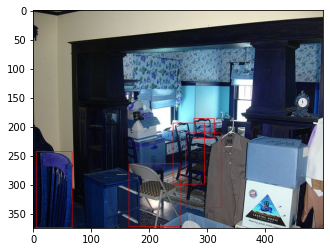

In [9]:
# 의자가 다수 존재하는 예제 이미지를 그려봅니다.
test_img_name = '000005.jpg'
test_img_path = f'./VOC2007/voc2007_images/{test_img_name}'

img = cv2.imread(test_img_path)
h, w, _ = img.shape

for obj in gt[test_img_name]:
  xmin, ymin, xmax, ymax = bbox_depreprocessing(obj[:4], w, h)
  cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (255, 0, 0), 1)
  plt.imshow(img)

plt.show()

In [10]:
# 학습 및 검증 데이터를 8:2로 나누도록 하겠습니다.
num_train = int(round(0.8 * len(keys)))

train_keys = keys[:num_train] # 4009개로 이루어집니다.
val_keys = keys[num_train:] # 1002개로 이루어집니다.
num_val = len(val_keys)

print(f'train data: {len(train_keys)}, val data: {len(val_keys)}')
print(f'total of data: {len(keys)}')

train data: 4009, val data: 1002
total of data: 5011


In [11]:
# 데이터셋 객체는 이미지(로드)와 레이블을 반환하도록 구성합니다.
# 먼저, 이미지 경로와 해당 값을 리스트에 저장해두도록 하겠습니다.
image_dir_list = list()
label_list = list()

# for testing, only use BATCH SIZE
for i in range(len(train_keys)):
    image_dir_list.append(train_keys[i]) # 이미지 경로 저장
    label_list.append(gt[train_keys[i]]) # label 저장

image_dir_list = np.array(image_dir_list)
image_dir_ds = tf.data.Dataset.from_tensor_slices(image_dir_list)

# 실험해볼 모델은 SSD300이므로 이미지 크기를 300으로 resize 합니다.
def get_imageLabel(image_dir):
    image = tf.io.read_file(IMAGE_PATH + image_dir)
    image = tf.image.decode_jpeg(image)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])

    return image

autotune = tf.data.experimental.AUTOTUNE

image_ds = image_dir_ds.map(get_imageLabel, num_parallel_calls=autotune)
image_ds = image_ds.shuffle(8 * BATCH_SIZE)
image_ds = image_ds.batch(BATCH_SIZE)
image_ds = image_ds.prefetch(autotune)

label_list = np.array(label_list)
# ragging data
# label에는 object가 다수 존재할 수 있기 때문에 이를 전부 펼쳐주기 위함입니다. 
ragged_label_list = tf.ragged.constant(label_list)
label_ds = tf.data.Dataset.from_tensor_slices(ragged_label_list)
label_ds = label_ds.shuffle(8 * BATCH_SIZE).batch(BATCH_SIZE)
label_ds = label_ds.prefetch(autotune)

In [12]:
# label은 (BATCH_SIZE, object 수, bbox 좌표 + 클래스 수)로 표현됩니다.
for image, label in zip(image_ds.take(1), label_ds.take(1)):
  print(image.shape, label.shape)
  print(label)

(16, 300, 300, 3) (16, None, None)
<tf.RaggedTensor [[[0.35, 0.3687315634218289, 0.688, 0.7492625368731564, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.106, 0.008849557522123894, 1.0, 0.9970501474926253, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [[0.0020161290322580645, 0.046, 0.9092741935483871, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [[0.004, 0.31044776119402984, 0.796, 0.9970149253731343, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [[0.056, 0.07630522088353414, 0.206, 0.6706827309236948, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.032, 0.21686746987951808, 0.356, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.

## Train Loop

In [196]:
# 모델을 생성합니다.
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
model = SSD(input_shape, num_classes = NUM_CLASSES)

model init


In [247]:
optimizer = Adam() # 최적화 함수를 선언합니다.
train_loss = MultiboxLoss(BATCH_SIZE) # 손실함수를 선언합니다.

for epoch in range(EPOCHS):
  print(f'===============EPOCHS: {epoch} start!==============')
  for image, label in zip(image_ds, label_ds):
      with tf.GradientTape() as tape:
          predictions = model(image)
          loss = train_loss.compute_loss(label, predictions)

          gradients = tape.gradient(loss, model.trainable_variables)
          optimizer.apply_gradients(zip(gradients, model.trainable_variables))

      print(f'epoch: {epoch} and loss: {loss}')

===============EPOCHS: 0 start!==============
tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(10, 1668), dtype=float32)


InvalidArgumentError: ignored